In [186]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
lya=1215.67

In [187]:
z_bin_centre = 2.25
z_bin_width = 0.2
z_bin = (z_bin_centre-z_bin_width/2,z_bin_centre+z_bin_width/2)
beta = 1.65
lambda_min = 3550.0

In [188]:
#Trim the skewers to a narrow window around the z value selected
#Get the growth factor and any other useful things
master = fits.open('/Users/jfarr/Projects/test_data/process_output_G_hZ_4096_32_sr2.0_bm1_nside16/nside_16_master.fits')
Z = master[2].data['Z']
lambdas = lya*(1+Z)
first_relevant_cell = np.argmax(lambdas>lambda_min)
D = master[2].data['D'][first_relevant_cell:]
Z = Z[first_relevant_cell:]

In [189]:
def lognormal_transform(delta_G_rows,sigma_G,D):
    density_rows = np.zeros(delta_G_rows.shape)
    for j in range(delta_G_rows.shape[1]):
        D_j = D[j]
        density_rows[:,j] = np.exp(D_j*delta_G_rows[:,j]-(D_j**2)*(sigma_G**2)/2.)
    return density_rows

In [190]:
def get_mean_F_model(z):
    return np.exp((np.log(0.8))*(((1+z)/3.25)**3.2))

In [191]:
def delta_G_to_delta_F(delta_G_rows,alpha,beta,D,sigma_G,IVAR_rows=None,mean_F=None):
    density_rows = lognormal_transform(delta_G_rows,sigma_G,D)
    F_rows = np.exp(-alpha*(density_rows**beta))
    if not mean_F:
        mean_F = np.average(F_rows,weights=IVAR_rows)
    delta_F_rows = F_rows/mean_F - 1
    return density_rows,F_rows,mean_F,delta_F_rows

In [192]:
def density_to_flux(density,alpha,beta):
    F = np.exp(-alpha*(density**beta))
    return F

In [203]:
def get_flux_stats(z,sigma_G,alpha,beta,mean_only=False,show_plot=False):

    int_lim_fac = 10.0
    int_lim = sigma_G*int_lim_fac
    
    delta_G_integral = np.linspace(-int_lim,int_lim,num=10**4)
    delta_G_integral = np.reshape(delta_G_integral,(1,delta_G_integral.shape[0]))
    
    D_value = D[np.argmax(Z>z_bin_centre)]
    D_integral = (D_value)*np.ones(delta_G_integral.shape[1])

    prob_delta_G = (1/((np.sqrt(2*np.pi))*sigma_G))*np.exp(-(delta_G_integral**2)/(2*(sigma_G**2)))
    
    density_integral = lognormal_transform(delta_G_integral,sigma_G,D_integral)
    F_integral = density_to_flux(density_integral,alpha,beta)
        
    mean_F = np.trapz(prob_delta_G*F_integral,delta_G_integral)[0]
    
    delta_F_integral = F_integral/mean_F - 1
    
    if mean_only == False:
        integrand = prob_delta_G*(delta_F_integral**2)
        sigma_F = np.sqrt(np.trapz(integrand,delta_G_integral)[0])
    else:
        sigma_F = None
    
    if show_plot == True:
        plt.scatter(delta_G_integral,prob_delta_G*F_integral,label='mean F')
        plt.scatter(delta_G_integral,prob_delta_G*(delta_F_integral**2),label='var F')
        plt.ylabel('integrand')
        plt.xlabel('delta_G')
        plt.title('alpha: {}'.format(alpha))
        plt.legend()
        plt.grid()
        plt.show()
    
    return mean_F, sigma_F

In [204]:
sigma_G_values = np.linspace(0.1,10,10)
print('{} <= sigma_G <= {}'.format(np.min(sigma_G_values),np.max(sigma_G_values)))
print('{} values of sigma_G will be tested'.format(sigma_G_values.shape[0]))

0.1 <= sigma_G <= 10.0
10 values of sigma_G will be tested


In [205]:
tolerance = 0.0001

mean_F_model = get_mean_F_model(z_bin_centre)
print('mean F model {}\n'.format(mean_F_model))

results = []

for sigma_G in sigma_G_values:
    
    alpha_low = 0.0
    alpha_high = 1000.0
    
    alpha_log_low = -3.
    alpha_log_high = 10
    
    count = 0
    exit = 0
    
    while exit == 0 and count < 30:
        alpha_midpoint = (alpha_low + alpha_high)/2.0
        alpha_log_midpoint = (alpha_log_low + alpha_log_high)/2.0
        """
        mean_F_al,sigma_F_al = get_flux_stats(z_bin_centre,sigma_G,alpha_low,beta,mean_only=True)
        mean_F_am,sigma_F_am = get_flux_stats(z_bin_centre,sigma_G,alpha_midpoint,beta,mean_only=True)
        mean_F_ah,sigma_F_ah = get_flux_stats(z_bin_centre,sigma_G,alpha_high,beta,mean_only=True)
        """
        mean_F_al,sigma_F_al = get_flux_stats(z_bin_centre,sigma_G,10**alpha_log_low,beta,mean_only=True)
        mean_F_am,sigma_F_am = get_flux_stats(z_bin_centre,sigma_G,10**alpha_log_midpoint,beta,mean_only=True)
        mean_F_ah,sigma_F_ah = get_flux_stats(z_bin_centre,sigma_G,10**alpha_log_high,beta,mean_only=True)

        #print('model: {:2.4f}, ({:2.2f},{:2.2f},{:2.2f}), ({:2.2f},{:2.2f},{:2.2f})'.format(mean_F_model,alpha_low,alpha_midpoint,alpha_high,mean_F_al,mean_F_am,mean_F_ah))
        if np.sign(mean_F_al-mean_F_model) * np.sign(mean_F_am-mean_F_model) > 0:
            alpha_low = alpha_midpoint
            alpha_log_low = alpha_log_midpoint
        else:
            alpha_high = alpha_midpoint
            alpha_log_high = alpha_log_midpoint
                
        if abs(mean_F_am/mean_F_model - 1) < tolerance:
            exit = 1
        else:
            count += 1
            
    alpha = alpha_midpoint
    alpha = 10**alpha_log_midpoint
    mean_F,sigma_F = get_flux_stats(z_bin_centre,sigma_G,alpha,beta)
    
    results += [(sigma_G,sigma_F)]
    print('sigma G {:2.2f}, alpha {:2.2f}: mean F {:2.4f}, sigma F {:2.4f}, n {:3d}'.format(sigma_G,alpha,mean_F,sigma_F,count))
    
results = np.array(results)

mean F model 0.8



/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


sigma G 0.10, alpha 0.22: mean F 0.8000, sigma F 0.0144, n  15
sigma G 1.20, alpha 0.22: mean F 0.7999, sigma F 0.1701, n  12
sigma G 2.30, alpha 0.23: mean F 0.8000, sigma F 0.2834, n  12
sigma G 3.40, alpha 0.30: mean F 0.8001, sigma F 0.3466, n  13
sigma G 4.50, alpha 0.51: mean F 0.7999, sigma F 0.3837, n  13
sigma G 5.60, alpha 1.17: mean F 0.8000, sigma F 0.4070, n  12
sigma G 6.70, alpha 3.60: mean F 0.8000, sigma F 0.4227, n  12
sigma G 7.80, alpha 14.97: mean F 0.8000, sigma F 0.4342, n  12
sigma G 8.90, alpha 83.98: mean F 0.7999, sigma F 0.4428, n  12
sigma G 10.00, alpha 635.84: mean F 0.8000, sigma F 0.4494, n  12


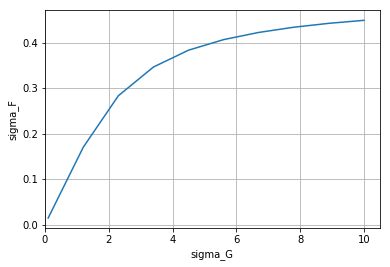

In [206]:
plt.plot(results[:,0],results[:,1])
plt.ylabel('sigma_F')
plt.xlabel('sigma_G')
plt.xlim(xmin=0.0)
plt.grid()
plt.show()

In [17]:
#Get the gaussian delta skewers
h = fits.open('/Users/James/Projects/test_data/process_output_G_hZ_4096_32_sr2.0_bm1_nside16/10/1064/picca-gaussian-16-1064.fits')
delta_G_rows = h[0].data.T
IVAR_rows = h[1].data.T
#delta_G_rows = delta_G_rows[0,:]


first_valid_cell = np.argmax(Z>z_bin[0])
last_valid_cell = np.argmax(Z>z_bin[1]) - 1
valid_rows = Z_QSO>z_bin[0]

D = D[first_valid_cell:last_valid_cell]
Z = Z[first_valid_cell:last_valid_cell]
delta_G_rows = delta_G_rows[:,first_valid_cell:last_valid_cell]
delta_G_rows = delta_G_rows[valid_rows,:]
IVAR_rows = IVAR_rows[:,first_valid_cell:last_valid_cell]
IVAR_rows = IVAR_rows[valid_rows,:]
Z_QSO = Z_QSO[valid_rows]

print('we have {} skewers, each with {} cells'.format(delta_G_rows.shape[0],delta_G_rows.shape[1]))
print('cells are in the z-range: {:2.2f} < z < {:2.2f}'.format(np.min(Z),np.max(Z)))

we have 7 skewers, each with 75 cells
cells are in the z-range: 2.15 < z < 2.35


check that the skewers aren't just empty:


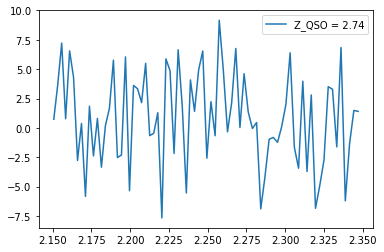

In [18]:
print('check that the skewers aren\'t just empty:')
n = np.random.randint(0,high=len(Z_QSO))
plt.plot(Z,delta_G_rows[n,:],label='Z_QSO = {:2.2f}'.format(Z_QSO[n]))
plt.legend()
plt.show()